In [1]:
! pip install pytorch-metric-learning
! pip install MulticoreTSNE

In [2]:
import timm
import torch
from torch import optim
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch import optim
import os

import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
from pytorch_metric_learning.miners import TripletMarginMiner
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning import losses, testers

from PIL import Image
import argparse

In [3]:
def args():
    def str2bool(v):
        if v.lower() in ('yes', 'true', 't', 'y', '1'):
            return True
        elif v.lower() in ('no', 'false', 'f', 'n', '0'):
            return False
        else:
            raise argparse.ArgumentTypeError('Unsupported value encountered.')
    
    #
    parser.add_argument('--data_path', default='./dataset/', type=str, dest='data_path')
    parser.add_argument('--exp', default=0, type=int, dest='exp')
    parser.add_argument('--seed', default=42, type=int, dest='seed')
    parser.add_argument('--debug', default=False, type=bool, dest='debug')
    
    parser.add_argument('--model_name', default='resnet34d', type=str, dest='model_name')
    parser.add_argument('--loss_name', default="TripletMargin", type=str, dest='loss_name')
    parser.add_argument('--distance_name', default="CosineSimilarity", type=str, dest='distance_name')

    parser.add_argument('--epoch', default=20, type=int, dest='epoch')
    parser.add_argument('--pretrained', default=True, type=bool, dest='pretrained')
    parser.add_argument('--inp_channels', default=3, type=int, dest='inp_channels')
    parser.add_argument('--batch_size', default=64, type=int, dest='batch_size')
    parser.add_argument('--lr', default=1e-5, type=float, dest='lr')
    parser.add_argument('--out_features', default=128, type=int, dest='out_features')
    
    
    # python
    #args = parser.parse_args()

    # jupyter
    args_parser = parser.parse_args(args=['--exp', '4',
                                         '--loss_name', 'CosFace',
                                         '--inp_channels', '1',
                                         #'--debug', 'True'
                                         ])
    return args_parser

In [4]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
def dataset():
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    train_dataset = datasets.FashionMNIST(CFG.data_path, train=True, download=False, transform=transform)
    test_dataset = datasets.FashionMNIST(CFG.data_path, train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)
    
    return train_loader, test_loader

In [6]:
class CustomModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.backbone = timm.create_model(
            model_name=CFG.model_name, pretrained=CFG.pretrained, num_classes=CFG.out_features, in_chans=CFG.inp_channels)
      
    def forward(self, x):
        x = self.backbone(x)
        output = x
        return output

In [7]:
def train(model, loss_func, mining_func, device, dataloader, optimizer, epoch):
    model.train() 
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        if mining_func == None:
            embeddings = model(inputs)
            loss = loss_func(embeddings, labels)
        else:
            embeddings = model(inputs)
            indices_tuple = mining_func(embeddings, labels)
            loss = loss_func(embeddings, labels, indices_tuple)

        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print('Epoch {} Iteration {}: Loss = {}'.format(epoch, idx, loss))

In [8]:
def test(model, dataloader, device, epoch):
    _predicted_metrics = []
    _true_labels = []
    with torch.no_grad():    
        for i, (inputs,  labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            metric = model(inputs).detach().cpu().numpy()
            metric = metric.reshape(metric.shape[0], metric.shape[1])
            _predicted_metrics.append(metric)
            _true_labels.append(labels.detach().cpu().numpy())
    return np.concatenate(_predicted_metrics), np.concatenate(_true_labels)

In [9]:
def tsne(epoch):
    inf_model = CustomModel(CFG).to(CFG.device)
    inf_model.load_state_dict(torch.load(OUTPUT_DIR + "/" + f'epoch{epoch}_model.pth'))
    test_predicted_metrics, test_true_labels = test(inf_model, test_loader, CFG.device, epoch)
    tSNE_metrics = TSNE(n_components=2, random_state=CFG.seed,n_jobs=4).fit_transform(test_predicted_metrics)

    plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=test_true_labels)
    plt.colorbar()
    plt.xlim([-40,40])
    plt.ylim([-40,40])
    plt.title(f"epoch{epoch}")
    plt.savefig(OUTPUT_DIR + "/" + f"output_epoch{epoch}.jpg")
    plt.show()

In [10]:
def create_gif():
    pictures=[]
    for i in range(1,CFG.epoch+1):
        pic_name=OUTPUT_DIR + f"output_epoch{i}.jpg"
        img = Image.open(pic_name)
        pictures.append(img)
    
    pictures[0].save(OUTPUT_DIR + "/" + f'{CFG.loss_name}.gif',save_all=True, append_images=pictures[1:],
    optimize=False, duration=500, loop=0)

False
Epoch 1/20
----------
Epoch 1 Iteration 0: Loss = 30.90568733215332
Epoch 1 Iteration 100: Loss = 28.49656105041504
Epoch 1 Iteration 200: Loss = 27.941028594970703
Epoch 1 Iteration 300: Loss = 25.93498992919922
Epoch 1 Iteration 400: Loss = 24.542537689208984
Epoch 1 Iteration 500: Loss = 21.464445114135742
Epoch 1 Iteration 600: Loss = 22.152292251586914
Epoch 1 Iteration 700: Loss = 20.04153060913086
Epoch 1 Iteration 800: Loss = 19.789630889892578
Epoch 1 Iteration 900: Loss = 19.21622085571289


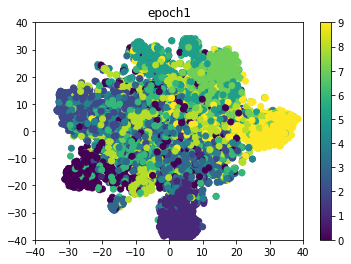

Epoch 2/20
----------
Epoch 2 Iteration 0: Loss = 14.431907653808594
Epoch 2 Iteration 100: Loss = 19.275135040283203
Epoch 2 Iteration 200: Loss = 15.996419906616211
Epoch 2 Iteration 300: Loss = 17.593055725097656
Epoch 2 Iteration 400: Loss = 14.47627067565918
Epoch 2 Iteration 500: Loss = 14.562217712402344
Epoch 2 Iteration 600: Loss = 14.059969902038574
Epoch 2 Iteration 700: Loss = 13.51162052154541
Epoch 2 Iteration 800: Loss = 12.145953178405762
Epoch 2 Iteration 900: Loss = 8.943700790405273


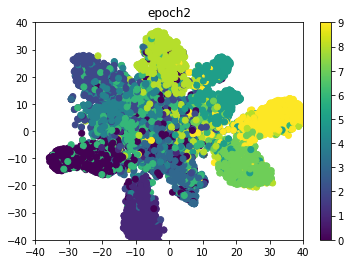

Epoch 3/20
----------
Epoch 3 Iteration 0: Loss = 8.745079040527344
Epoch 3 Iteration 100: Loss = 10.53763484954834
Epoch 3 Iteration 200: Loss = 10.980306625366211
Epoch 3 Iteration 300: Loss = 12.569581031799316
Epoch 3 Iteration 400: Loss = 11.443857192993164
Epoch 3 Iteration 500: Loss = 10.066902160644531
Epoch 3 Iteration 600: Loss = 12.459697723388672
Epoch 3 Iteration 700: Loss = 8.748429298400879
Epoch 3 Iteration 800: Loss = 11.636458396911621
Epoch 3 Iteration 900: Loss = 12.137971878051758


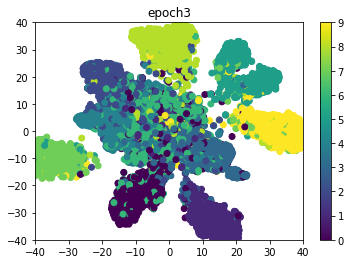

Epoch 4/20
----------
Epoch 4 Iteration 0: Loss = 8.6371488571167
Epoch 4 Iteration 100: Loss = 11.140863418579102
Epoch 4 Iteration 200: Loss = 7.066217422485352
Epoch 4 Iteration 300: Loss = 6.564399719238281
Epoch 4 Iteration 400: Loss = 10.459442138671875
Epoch 4 Iteration 500: Loss = 10.6715669631958
Epoch 4 Iteration 600: Loss = 7.911872386932373
Epoch 4 Iteration 700: Loss = 9.71556282043457
Epoch 4 Iteration 800: Loss = 6.717960357666016
Epoch 4 Iteration 900: Loss = 11.815006256103516


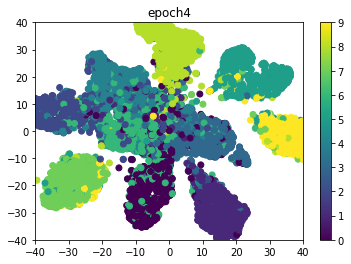

Epoch 5/20
----------
Epoch 5 Iteration 0: Loss = 8.793463706970215
Epoch 5 Iteration 100: Loss = 9.669150352478027
Epoch 5 Iteration 200: Loss = 6.3867621421813965
Epoch 5 Iteration 300: Loss = 5.63731050491333
Epoch 5 Iteration 400: Loss = 7.066661834716797
Epoch 5 Iteration 500: Loss = 8.685188293457031
Epoch 5 Iteration 600: Loss = 8.856968879699707
Epoch 5 Iteration 700: Loss = 7.515261650085449
Epoch 5 Iteration 800: Loss = 7.83634090423584
Epoch 5 Iteration 900: Loss = 6.358469009399414


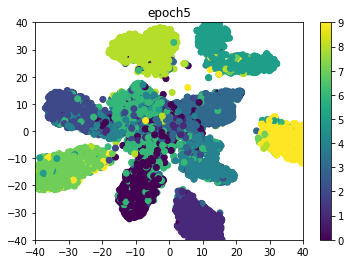

Epoch 6/20
----------
Epoch 6 Iteration 0: Loss = 7.921478271484375
Epoch 6 Iteration 100: Loss = 7.571771621704102
Epoch 6 Iteration 200: Loss = 7.874715328216553
Epoch 6 Iteration 300: Loss = 6.15808629989624
Epoch 6 Iteration 400: Loss = 4.458249568939209
Epoch 6 Iteration 500: Loss = 5.4803972244262695
Epoch 6 Iteration 600: Loss = 6.832402229309082
Epoch 6 Iteration 700: Loss = 6.281301975250244
Epoch 6 Iteration 800: Loss = 5.230139255523682
Epoch 6 Iteration 900: Loss = 5.816898345947266


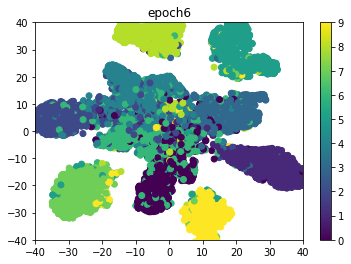

Epoch 7/20
----------
Epoch 7 Iteration 0: Loss = 4.748672008514404
Epoch 7 Iteration 100: Loss = 4.362870693206787
Epoch 7 Iteration 200: Loss = 5.208774566650391
Epoch 7 Iteration 300: Loss = 7.374235153198242
Epoch 7 Iteration 400: Loss = 6.467372417449951
Epoch 7 Iteration 500: Loss = 4.842041015625
Epoch 7 Iteration 600: Loss = 6.991128444671631
Epoch 7 Iteration 700: Loss = 5.971638202667236
Epoch 7 Iteration 800: Loss = 7.0270538330078125
Epoch 7 Iteration 900: Loss = 4.670997619628906


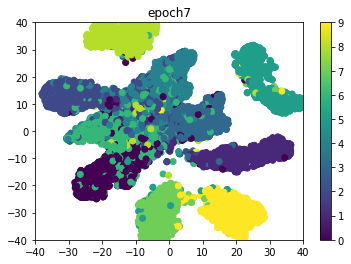

Epoch 8/20
----------
Epoch 8 Iteration 0: Loss = 9.783482551574707
Epoch 8 Iteration 100: Loss = 6.36960506439209
Epoch 8 Iteration 200: Loss = 5.838783264160156
Epoch 8 Iteration 300: Loss = 6.608084678649902
Epoch 8 Iteration 400: Loss = 4.609189987182617
Epoch 8 Iteration 500: Loss = 4.772990703582764
Epoch 8 Iteration 600: Loss = 4.648287296295166
Epoch 8 Iteration 700: Loss = 5.551236629486084
Epoch 8 Iteration 800: Loss = 6.275623798370361
Epoch 8 Iteration 900: Loss = 8.160207748413086


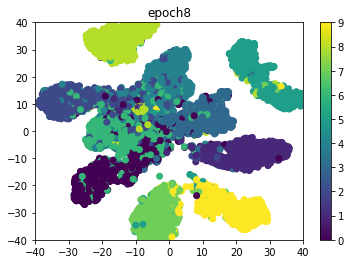

Epoch 9/20
----------
Epoch 9 Iteration 0: Loss = 7.291766166687012
Epoch 9 Iteration 100: Loss = 6.877185821533203
Epoch 9 Iteration 200: Loss = 6.3193817138671875
Epoch 9 Iteration 300: Loss = 2.040894031524658
Epoch 9 Iteration 400: Loss = 4.151732444763184
Epoch 9 Iteration 500: Loss = 5.076692581176758
Epoch 9 Iteration 600: Loss = 6.271198749542236
Epoch 9 Iteration 700: Loss = 8.586649894714355
Epoch 9 Iteration 800: Loss = 4.953839302062988
Epoch 9 Iteration 900: Loss = 5.870843887329102


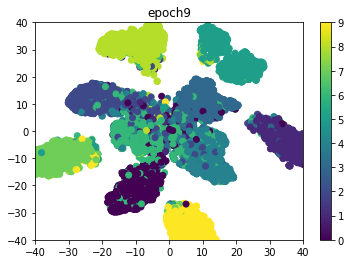

Epoch 10/20
----------
Epoch 10 Iteration 0: Loss = 2.622000217437744
Epoch 10 Iteration 100: Loss = 4.790594100952148
Epoch 10 Iteration 200: Loss = 4.240879535675049
Epoch 10 Iteration 300: Loss = 5.590702056884766
Epoch 10 Iteration 400: Loss = 1.0043104887008667
Epoch 10 Iteration 500: Loss = 3.030869960784912
Epoch 10 Iteration 600: Loss = 2.2225027084350586
Epoch 10 Iteration 700: Loss = 2.1630301475524902
Epoch 10 Iteration 800: Loss = 7.752074718475342
Epoch 10 Iteration 900: Loss = 5.635433197021484


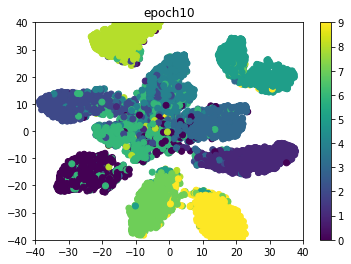

Epoch 11/20
----------
Epoch 11 Iteration 0: Loss = 5.749859809875488
Epoch 11 Iteration 100: Loss = 4.245868682861328
Epoch 11 Iteration 200: Loss = 3.6511423587799072
Epoch 11 Iteration 300: Loss = 6.023526191711426
Epoch 11 Iteration 400: Loss = 5.320555686950684
Epoch 11 Iteration 500: Loss = 3.2540459632873535
Epoch 11 Iteration 600: Loss = 2.674452066421509
Epoch 11 Iteration 700: Loss = 5.496592998504639
Epoch 11 Iteration 800: Loss = 4.580730438232422
Epoch 11 Iteration 900: Loss = 3.453963041305542


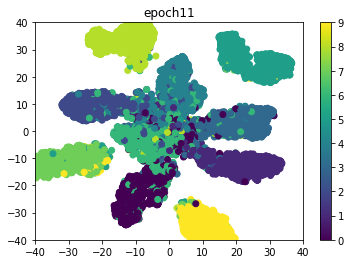

Epoch 12/20
----------
Epoch 12 Iteration 0: Loss = 4.875825881958008
Epoch 12 Iteration 100: Loss = 4.535107612609863
Epoch 12 Iteration 200: Loss = 2.0757434368133545
Epoch 12 Iteration 300: Loss = 5.524597644805908
Epoch 12 Iteration 400: Loss = 7.007296562194824
Epoch 12 Iteration 500: Loss = 3.166682720184326
Epoch 12 Iteration 600: Loss = 3.1225666999816895
Epoch 12 Iteration 700: Loss = 3.343822479248047
Epoch 12 Iteration 800: Loss = 4.564487457275391
Epoch 12 Iteration 900: Loss = 2.0289111137390137


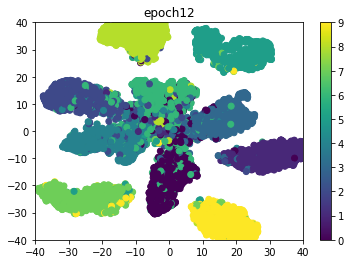

Epoch 13/20
----------
Epoch 13 Iteration 0: Loss = 3.2835710048675537
Epoch 13 Iteration 100: Loss = 4.517473220825195
Epoch 13 Iteration 200: Loss = 3.544179916381836
Epoch 13 Iteration 300: Loss = 3.932966470718384
Epoch 13 Iteration 400: Loss = 3.6235201358795166
Epoch 13 Iteration 500: Loss = 7.084917068481445
Epoch 13 Iteration 600: Loss = 3.3814749717712402
Epoch 13 Iteration 700: Loss = 5.041354179382324
Epoch 13 Iteration 800: Loss = 3.5532307624816895
Epoch 13 Iteration 900: Loss = 5.6072893142700195


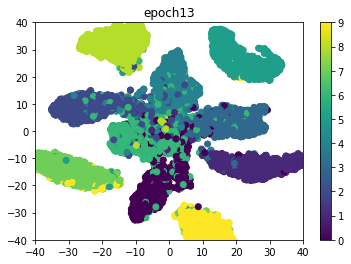

Epoch 14/20
----------
Epoch 14 Iteration 0: Loss = 8.139842987060547
Epoch 14 Iteration 100: Loss = 4.463254928588867
Epoch 14 Iteration 200: Loss = 2.2221155166625977
Epoch 14 Iteration 300: Loss = 3.8717098236083984
Epoch 14 Iteration 400: Loss = 5.084509372711182
Epoch 14 Iteration 500: Loss = 7.034104824066162
Epoch 14 Iteration 600: Loss = 4.317774295806885
Epoch 14 Iteration 700: Loss = 2.809657096862793
Epoch 14 Iteration 800: Loss = 3.1496496200561523
Epoch 14 Iteration 900: Loss = 2.348125457763672


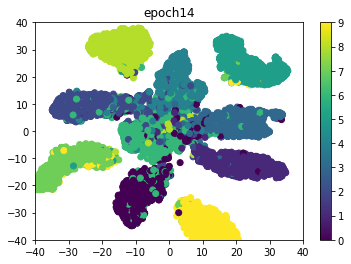

Epoch 15/20
----------
Epoch 15 Iteration 0: Loss = 4.147073745727539
Epoch 15 Iteration 100: Loss = 2.5050301551818848
Epoch 15 Iteration 200: Loss = 3.457045078277588
Epoch 15 Iteration 300: Loss = 3.4026083946228027
Epoch 15 Iteration 400: Loss = 2.2253756523132324
Epoch 15 Iteration 500: Loss = 3.985442638397217
Epoch 15 Iteration 600: Loss = 2.673403739929199
Epoch 15 Iteration 700: Loss = 2.107158660888672
Epoch 15 Iteration 800: Loss = 6.821569442749023
Epoch 15 Iteration 900: Loss = 4.333019256591797


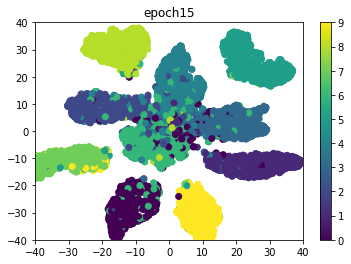

Epoch 16/20
----------
Epoch 16 Iteration 0: Loss = 3.4947142601013184
Epoch 16 Iteration 100: Loss = 3.499830961227417
Epoch 16 Iteration 200: Loss = 4.261348247528076
Epoch 16 Iteration 300: Loss = 2.732917547225952
Epoch 16 Iteration 400: Loss = 2.9314939975738525
Epoch 16 Iteration 500: Loss = 3.989865303039551
Epoch 16 Iteration 600: Loss = 5.702978134155273
Epoch 16 Iteration 700: Loss = 6.959354400634766
Epoch 16 Iteration 800: Loss = 5.380594730377197
Epoch 16 Iteration 900: Loss = 2.6279492378234863


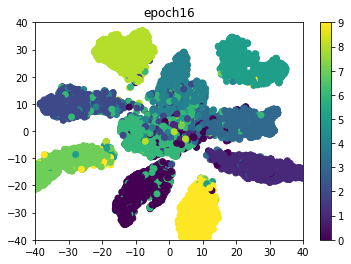

Epoch 17/20
----------
Epoch 17 Iteration 0: Loss = 3.1852025985717773
Epoch 17 Iteration 100: Loss = 4.273274898529053
Epoch 17 Iteration 200: Loss = 2.9669101238250732
Epoch 17 Iteration 300: Loss = 3.3272600173950195
Epoch 17 Iteration 400: Loss = 3.566119909286499
Epoch 17 Iteration 500: Loss = 3.666807174682617
Epoch 17 Iteration 600: Loss = 2.738205671310425
Epoch 17 Iteration 700: Loss = 2.8638739585876465
Epoch 17 Iteration 800: Loss = 1.66339111328125
Epoch 17 Iteration 900: Loss = 2.1437864303588867


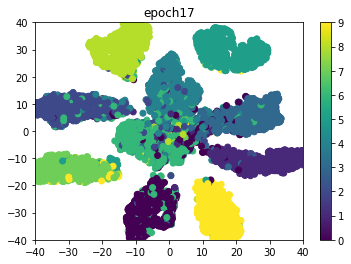

Epoch 18/20
----------
Epoch 18 Iteration 0: Loss = 2.3926517963409424
Epoch 18 Iteration 100: Loss = 3.386247158050537
Epoch 18 Iteration 200: Loss = 4.358639717102051
Epoch 18 Iteration 300: Loss = 3.131074905395508
Epoch 18 Iteration 400: Loss = 1.8457705974578857
Epoch 18 Iteration 500: Loss = 3.002927303314209
Epoch 18 Iteration 600: Loss = 4.5797319412231445
Epoch 18 Iteration 700: Loss = 3.339336395263672
Epoch 18 Iteration 800: Loss = 3.312006711959839
Epoch 18 Iteration 900: Loss = 1.6974937915802002


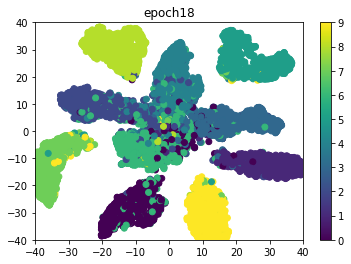

Epoch 19/20
----------
Epoch 19 Iteration 0: Loss = 2.3770759105682373
Epoch 19 Iteration 100: Loss = 2.306736707687378
Epoch 19 Iteration 200: Loss = 3.742366313934326
Epoch 19 Iteration 300: Loss = 3.5865280628204346
Epoch 19 Iteration 400: Loss = 0.0763087123632431
Epoch 19 Iteration 500: Loss = 3.435610771179199
Epoch 19 Iteration 600: Loss = 2.9734766483306885
Epoch 19 Iteration 700: Loss = 3.697939872741699
Epoch 19 Iteration 800: Loss = 0.538301944732666
Epoch 19 Iteration 900: Loss = 4.391688823699951


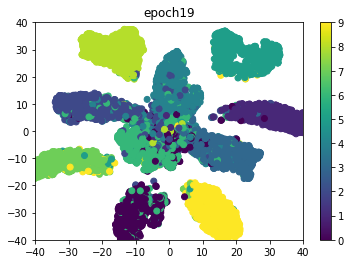

Epoch 20/20
----------
Epoch 20 Iteration 0: Loss = 2.8864645957946777
Epoch 20 Iteration 100: Loss = 2.6003246307373047
Epoch 20 Iteration 200: Loss = 2.2915029525756836
Epoch 20 Iteration 300: Loss = 2.7284862995147705
Epoch 20 Iteration 400: Loss = 5.831490993499756
Epoch 20 Iteration 500: Loss = 2.599200487136841
Epoch 20 Iteration 600: Loss = 1.2537668943405151
Epoch 20 Iteration 700: Loss = 0.9638992547988892
Epoch 20 Iteration 800: Loss = 2.9154653549194336
Epoch 20 Iteration 900: Loss = 2.1271908283233643


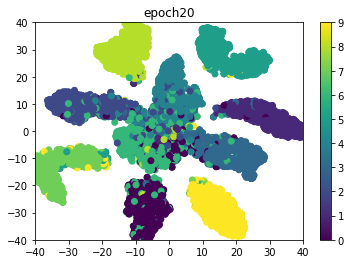

In [11]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    CFG = args()
    
    CFG.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    print(CFG.debug)
    if CFG.debug:
        CFG.epoch = 1
    seed_everything(seed=CFG.seed)
    
    OUTPUT_DIR = './'+'ex'+str(CFG.exp)+'/'+ CFG.loss_name +'/'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        
    train_loader, test_loader = dataset()
    
    
    model = CustomModel(CFG).to(CFG.device)
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
    
    test_predicted_metrics = []
    test_true_labels = []
    model_loss = 0
    best_model_loss = 100
    
    if CFG.distance_name == 'CosineSimilarity':
        distance = CosineSimilarity()

    if CFG.loss_name == 'TripletMargin':
        reducer = ThresholdReducer(low = 0)
        loss_func = TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
        mining_func = TripletMarginMiner(margin=0.2, distance=distance)
        
    elif CFG.loss_name == 'SubCenterArcFace':
        loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=128,distance=distance,).to(CFG.device)
    elif CFG.loss_name == 'CosFace':
        loss_func = losses.CosFaceLoss(num_classes=10, embedding_size=128,distance=distance).to(CFG.device)
    elif CFG.loss_name == 'ArcFace':
        loss_func = losses.ArcFaceLoss(num_classes=10, embedding_size=128,distance=distance).to(CFG.device)
    elif CFG.loss_name == 'Contrastive':
        loss_func = losses.ContrastiveLoss(pos_margin=0, neg_margin=1,distance=distance).to(CFG.device)
    elif CFG.loss_name == 'Circle':
        loss_func = losses.CircleLoss(m=0.4, gamma=80,distance=distance).to(CFG.device)
    
    for epoch in range(1, CFG.epoch + 1):
        print('Epoch {}/{}'.format(epoch, CFG.epoch))
        print('-' * 10)
        if CFG.loss_name == 'TripletMargin': 
            train(model, loss_func, mining_func, CFG.device, train_loader, optimizer, epoch)
        else:
            mining_func = None
            train(model, loss_func, mining_func, CFG.device, train_loader, optimizer, epoch)
            
        torch.save(model.state_dict(),OUTPUT_DIR + "/" + f'epoch{epoch}_model.pth')
        tsne(epoch)
    
    #create gif 
    create_gif()